# Predicting Temperature in London

![tower_bridge](tower_bridge.jpeg)

As the climate changes, predicting the weather becomes ever more important for businesses. Since the weather depends on a lot of different factors, i will want to run a lot of experiments to determine what the best approach is to predict the weather. In this project, i will run experiments for different regression models predicting the mean temperature, using a combination of `sklearn` and `MLflow`.

You will be working with data stored in `london_weather.csv`, which contains the following columns:
- **date** - recorded date of measurement - (**int**)
- **cloud_cover** - cloud cover measurement in oktas - (**float**)
- **sunshine** - sunshine measurement in hours (hrs) - (**float**)
- **global_radiation** - irradiance measurement in Watt per square meter (W/m2) - (**float**)
- **max_temp** - maximum temperature recorded in degrees Celsius (°C) - (**float**)
- **mean_temp** - mean temperature in degrees Celsius (°C) - (**float**)
- **min_temp** - minimum temperature recorded in degrees Celsius (°C) - (**float**)
- **precipitation** - precipitation measurement in millimeters (mm) - (**float**)
- **pressure** - pressure measurement in Pascals (Pa) - (**float**)
- **snow_depth** - snow depth measurement in centimeters (cm) - (**float**)

In [156]:
# Run this cell to import the modules you require
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from mlflow.models import ModelSignature, infer_signature
from mlflow.types import Schema, ColSpec
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Read in the data
weather = pd.read_csv("london_weather.csv", parse_dates=[0], date_format="%Y%m%d")

# Convert date and extract information
weather['month'] = weather['date'].dt.month
weather['year'] = weather['date'].dt.year

In [157]:
# Perform exploratory data analysis and data cleaning
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              15341 non-null  datetime64[ns]
 1   cloud_cover       15322 non-null  float64       
 2   sunshine          15341 non-null  float64       
 3   global_radiation  15322 non-null  float64       
 4   max_temp          15335 non-null  float64       
 5   mean_temp         15305 non-null  float64       
 6   min_temp          15339 non-null  float64       
 7   precipitation     15335 non-null  float64       
 8   pressure          15337 non-null  float64       
 9   snow_depth        13900 non-null  float64       
 10  month             15341 non-null  int32         
 11  year              15341 non-null  int32         
dtypes: datetime64[ns](1), float64(9), int32(2)
memory usage: 1.3 MB


In [158]:
weather.describe()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,month,year
count,15341,15322.000000,15341.000000,15322.000000,15335.000000,15305.000000,15339.000000,15335.000000,15337.000000,13900.000000,15341.000000,15341.000000
mean,2000-01-01 00:00:00,5.268242,4.350238,118.756951,15.388777,11.475511,7.559867,1.668634,101536.605594,0.037986,6.522782,1999.500359
min,1979-01-01 00:00:00,0.000000,0.000000,8.000000,-6.200000,-7.600000,-11.800000,0.000000,95960.000000,0.000000,1.000000,1979.000000
25%,1989-07-02 00:00:00,4.000000,0.500000,41.000000,10.500000,7.000000,3.500000,0.000000,100920.000000,0.000000,4.000000,1989.000000
50%,2000-01-01 00:00:00,6.000000,3.500000,95.000000,15.000000,11.400000,7.800000,0.000000,101620.000000,0.000000,7.000000,2000.000000
75%,2010-07-02 00:00:00,7.000000,7.200000,186.000000,20.300000,16.000000,11.800000,1.600000,102240.000000,0.000000,10.000000,2010.000000
max,2020-12-31 00:00:00,9.000000,16.000000,402.000000,37.900000,29.000000,22.300000,61.800000,104820.000000,22.000000,12.000000,2020.000000
std,NaN,2.070072,4.028339,88.898272,6.554754,5.729709,5.326756,3.738540,1049.722604,0.545633,3.448856,12.121708


In [159]:
weather.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,month,year
0,1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0,1,1979
1,1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0,1,1979
2,1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0,1,1979
3,1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0,1,1979
4,1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0,1,1979


<Axes: xlabel='year', ylabel='mean_temp'>

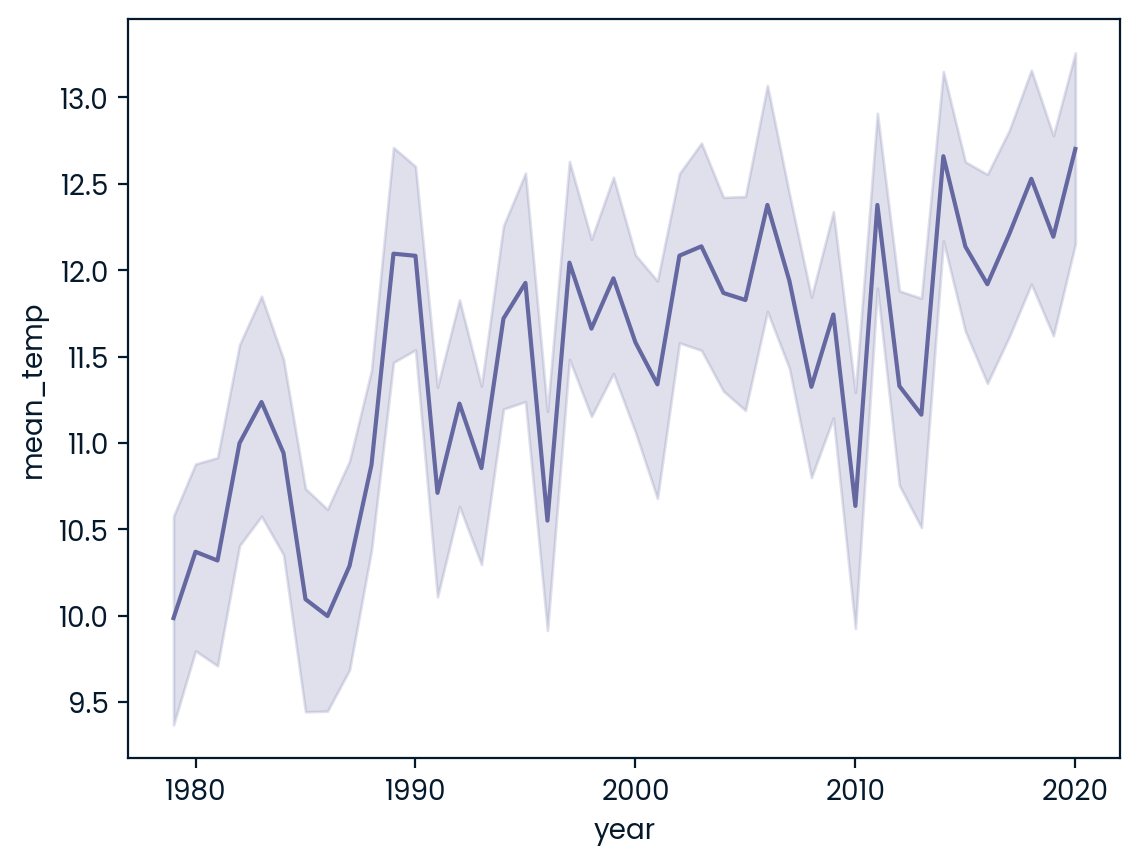

In [160]:
# Visualize relationships in the data
sns.lineplot(weather, x='year', y='mean_temp')

<Axes: xlabel='month', ylabel='mean_temp'>

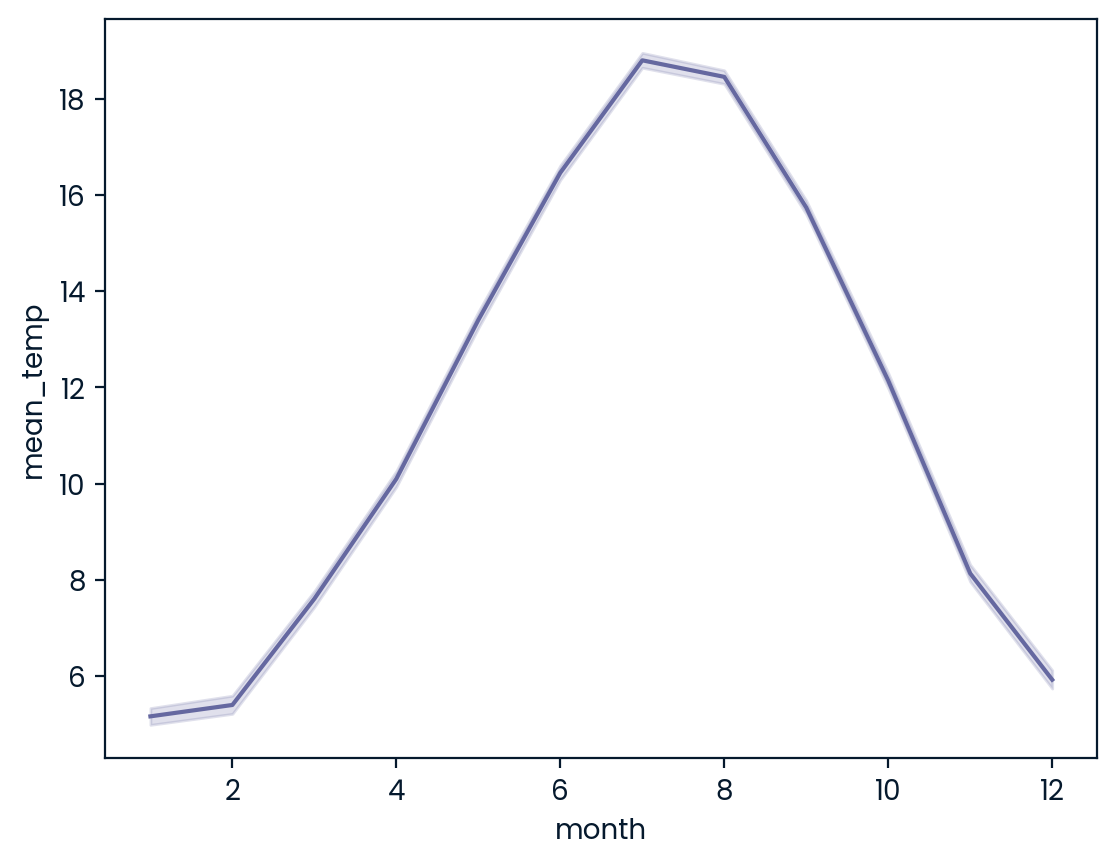

In [161]:
sns.lineplot(weather, x='month', y='mean_temp')

In [162]:
# Aggregate and calculate average metrics
weather_metrics = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth']
weather_per_month = weather.groupby(['year', 'month'], as_index = False)[weather_metrics].mean()

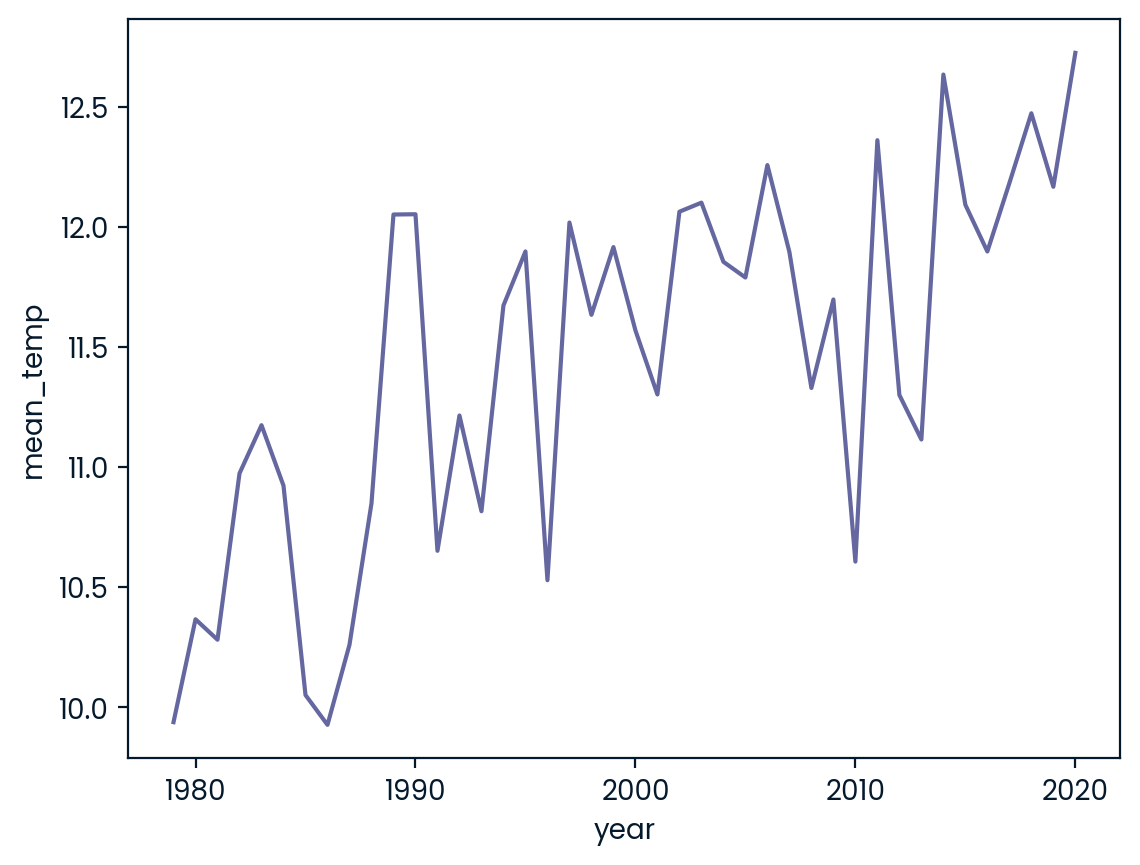

In [163]:
sns.lineplot(x="year", y="mean_temp", data=weather_per_month, ci=None)
plt.show()

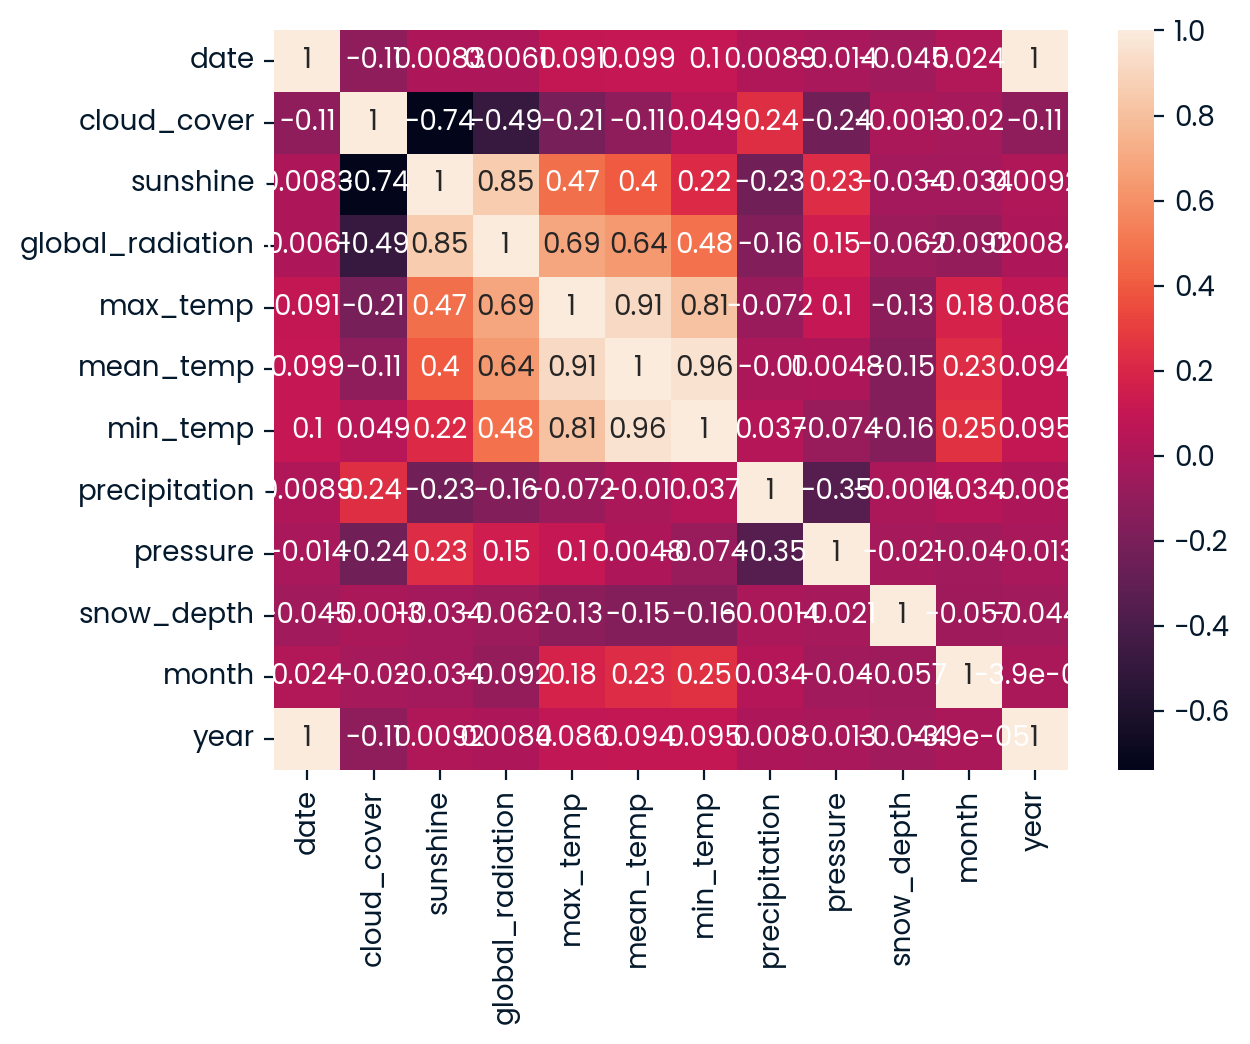

In [164]:
sns.heatmap(weather.corr(), annot=True)
plt.show()

In [165]:
# Choose features, define the target, and drop null values
feature_selection = ["cloud_cover", "sunshine","global_radiation", "snow_depth", "month"]
target = ["mean_temp"]
weather = weather.dropna(subset=['mean_temp'])

In [166]:
# Subset feature and target sets
X = weather[feature_selection]
Y = weather[target]

In [167]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)

In [168]:
# Impute missing values
imputer = SimpleImputer(strategy="mean")
# Fit on the training data
X_train = imputer.fit_transform(X_train)
# Transform on the test data
X_test  = imputer.transform(X_test)

In [169]:
def change_datatype(X_train, X_test, y_train, y_test):
    # Define data types for each column
    dtype_mapping = {
        0: np.int8,
        1: np.float16,
        2: np.int16,
        3: np.int8,
        4: np.int8
    }
    
    # If the data are DataFrames, convert them instead.
    if isinstance(X_train, pd.DataFrame):
        for col, dtype in dtype_mapping.items():
            X_train.iloc[:, col] = X_train.iloc[:, col].astype(dtype)
            X_test.iloc[:, col] = X_test.iloc[:, col].astype(dtype)
    else:  # If NumPy arrays
        for col, dtype in dtype_mapping.items():
            X_train[:, col] = X_train[:, col].astype(dtype)
            X_test[:, col] = X_test[:, col].astype(dtype)

    # Convert y_train and y_test correctly
    if isinstance(y_train, pd.DataFrame):
        y_train.iloc[:, 0] = y_train.iloc[:, 0].astype(np.float16)
        y_test.iloc[:, 0] = y_test.iloc[:, 0].astype(np.float16)
    else:
        y_train[:, 0] = y_train[:, 0].astype(np.float16)
        y_test[:, 0] = y_test[:, 0].astype(np.float16)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = change_datatype(X_train, X_test, y_train, y_test)

In [170]:
# Scale the data
scaler = StandardScaler()
# Fit on the training data
X_train = scaler.fit_transform(X_train)
# Transform on the test data
X_test = scaler.transform(X_test)

In [171]:
# Define signature
input_schema = Schema(
    [
        ColSpec("integer", name="cloud_cover"),
        ColSpec("float", name="sunshine"),
        ColSpec("integer", name="global_radiation"),
        ColSpec("integer", name="snow_depth"),
        ColSpec("integer", name="month")
    ]
)
output_schema = Schema([ColSpec("float", name="mean_temp"),])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

In [172]:
# Predict, evaluate, and log the parameters and metrics of your models
for idx, depth in enumerate([1, 2, 10]): 
    run_name = f"run_{idx}"
    with mlflow.start_run(run_name=run_name):
        
        # Create models
        lin_reg = LinearRegression().fit(X_train, y_train)
        tree_reg = DecisionTreeRegressor(random_state=42, max_depth=depth).fit(X_train, y_train)
        forest_reg = RandomForestRegressor(random_state=42, max_depth=depth).fit(X_train, y_train)
        
        # Log models
        mlflow.sklearn.log_model(lin_reg, "lin_reg", signature=signature)
        mlflow.sklearn.log_model(tree_reg, "tree_reg", signature=signature)
        mlflow.sklearn.log_model(forest_reg, "forest_reg", signature=signature)
        
        # Evaluate performance
        y_pred_lin_reg = lin_reg.predict(X_test)
        lin_reg_rmse = mean_squared_error(y_test, y_pred_lin_reg, squared=False)
        y_pred_tree_reg = tree_reg.predict(X_test)
        tree_reg_rmse = mean_squared_error(y_test, y_pred_tree_reg, squared=False)
        y_pred_forest_reg = forest_reg.predict(X_test)
        forest_reg_rmse = mean_squared_error(y_test, y_pred_forest_reg, squared=False)
        
        # Log performance
        mlflow.log_param("max_depth", depth)
        mlflow.log_metric("rmse_lr", lin_reg_rmse)
        mlflow.log_metric("rmse_tr", tree_reg_rmse)
        mlflow.log_metric("rmse_fr", forest_reg_rmse)

In [173]:
# Search the runs for the experiment's results
experiment_results = mlflow.search_runs()
experiment_results

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.rmse_lr,metrics.rmse_fr,metrics.rmse_tr,params.max_depth,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.log-model.history
0,45df3fe770254d3c84cb7b0335e8aa66,0,FINISHED,file:///work/files/workspace/mlruns/0/45df3fe7...,2025-03-29 19:10:00.430000+00:00,2025-03-29 19:10:13.610000+00:00,3.832538,2.775349,2.940167,10,repl,/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL,run_2,"[{""run_id"": ""45df3fe770254d3c84cb7b0335e8aa66""..."
1,e7c2e5e93408467c9eb61d5bcb99157c,0,FINISHED,file:///work/files/workspace/mlruns/0/e7c2e5e9...,2025-03-29 19:09:48.224000+00:00,2025-03-29 19:10:00.354000+00:00,3.832538,3.832180,3.917354,2,repl,/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL,run_1,"[{""run_id"": ""e7c2e5e93408467c9eb61d5bcb99157c""..."
2,da2cb4dc3e434ec2acdcc4448e5ef2f3,0,FINISHED,file:///work/files/workspace/mlruns/0/da2cb4dc...,2025-03-29 19:09:36.194000+00:00,2025-03-29 19:09:48.146000+00:00,3.832538,4.694672,4.752051,1,repl,/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL,run_0,"[{""run_id"": ""da2cb4dc3e434ec2acdcc4448e5ef2f3""..."
3,5e6c5c4c40ed4353bbb778c9265d2e53,0,FINISHED,file:///work/files/workspace/mlruns/0/5e6c5c4c...,2025-03-29 19:09:09.756000+00:00,2025-03-29 19:09:22.988000+00:00,3.832538,2.775349,2.940167,10,repl,/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL,run_2,"[{""run_id"": ""5e6c5c4c40ed4353bbb778c9265d2e53""..."
4,31a874b8eec64f83ac5fc7a5eae21bb4,0,FINISHED,file:///work/files/workspace/mlruns/0/31a874b8...,2025-03-29 19:08:57.317000+00:00,2025-03-29 19:09:09.676000+00:00,3.832538,3.832180,3.917354,2,repl,/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL,run_1,"[{""run_id"": ""31a874b8eec64f83ac5fc7a5eae21bb4""..."
5,929c05ae70114403aaddd7558b7335ab,0,FINISHED,file:///work/files/workspace/mlruns/0/929c05ae...,2025-03-29 19:08:45.088000+00:00,2025-03-29 19:08:57.245000+00:00,3.832538,4.694672,4.752051,1,repl,/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL,run_0,"[{""run_id"": ""929c05ae70114403aaddd7558b7335ab""..."
6,cefaa596c1d94187a46cdf142105dd84,0,FINISHED,file:///work/files/workspace/mlruns/0/cefaa596...,2025-03-29 19:06:52.529000+00:00,2025-03-29 19:07:05.797000+00:00,3.832538,2.775349,2.940167,10,repl,/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL,run_2,"[{""run_id"": ""cefaa596c1d94187a46cdf142105dd84""..."
7,f8781077c84d413197cda8e2836ea730,0,FINISHED,file:///work/files/workspace/mlruns/0/f8781077...,2025-03-29 19:06:40.241000+00:00,2025-03-29 19:06:52.454000+00:00,3.832538,3.832180,3.917354,2,repl,/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL,run_1,"[{""run_id"": ""f8781077c84d413197cda8e2836ea730""..."
8,704770189b2f4a8fb7177336b5555395,0,FINISHED,file:///work/files/workspace/mlruns/0/70477018...,2025-03-29 19:06:27.793000+00:00,2025-03-29 19:06:40.162000+00:00,3.832538,4.694672,4.752051,1,repl,/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL,run_0,"[{""run_id"": ""704770189b2f4a8fb7177336b5555395""..."
9,828c51eb66344b9f90452efa7a081392,0,FINISHED,file:///work/files/workspace/mlruns/0/828c51eb...,2025-03-29 18:46:16.250000+00:00,2025-03-29 18:46:29.312000+00:00,3.832538,2.775349,2.940167,10,repl,/usr/lib/python3/dist-packages/python_kernel/k...,LOCAL,run_2,"[{""run_id"": ""828c51eb66344b9f90452efa7a081392""..."


In [176]:
!pip freeze > "./requirements.txt"